# mkGPLVM in tensorflow
Very easy to use. A few lines is sufficient.

This update allow regularization and combining kernels on the same dimension. (What does it mean?)

Iteratively find the correct pattern.

In [5]:
%matplotlib inline

In [6]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np
import sklearn as skl


from cyclum.models.misc import cyclops
from cyclum import writer


import cyclum.tuning

cell_line = "PC3"

# mkGPLVM implemented in Tensorflow

This is the implementation of mkGPLVM in Tensorflow.

# Get PC3 data

In [7]:
raw_Y = pd.read_pickle('/home/shaoheng/Documents/data/McDavid/pc3_df.pkl').T

cpt = pd.read_pickle('/home/shaoheng/Documents/data/McDavid/pc3_cpt.pkl').values
print("Original dimesion %d cells x %d genes." % raw_Y.shape)
print(f"G0/G1 {sum(cpt == 'g0/g1')}, S {sum(cpt == 's')}, G2/M {sum(cpt == 'g2/m')}")

#expression_level = np.sum(2**raw_Y, axis=0)

#ind = np.argpartition(expression_level.values, -150)[-150:]
#genes = raw_Y.columns[np.argpartition(expression_level.values, -6)[-6:]]
#Y = raw_Y.loc[:, raw_Y.columns[ind]]
#Y.values[:, :] = preprocessing.scale(Y)
Y = preprocessing.scale(raw_Y)

N, D = Y.shape
print('After filtering %d Cells (instances) x %d Genes (features)'%(N, D))

Original dimesion 361 cells x 253 genes.
G0/G1 [85], S [141], G2/M [135]
After filtering 361 Cells (instances) x 253 Genes (features)


In [8]:
data = cyclops.prep(Y, variance_kept = 0.98)
data=skl.preprocessing.scale(data)

[0.41252094 0.56771112 0.65006782 0.706364   0.74983742 0.78348378
 0.81549558 0.84415122 0.86580322 0.88448572 0.9011258  0.91328678
 0.92265569 0.93158523 0.93898742 0.94585627 0.95213806 0.95681498
 0.96063007 0.96430297 0.96780729 0.97083859 0.9731324  0.97531975
 0.97725621 0.97917148 0.98083503 0.98216464 0.98325379 0.98426183
 0.98525422 0.98613864 0.98696637 0.9876846  0.98838084 0.98900137
 0.98954666 0.99003521 0.99049879 0.99092416 0.99131183 0.99166751
 0.99200842 0.99233945 0.992637   0.99293118 0.99319718 0.99344146
 0.99368035 0.99390887 0.99413709 0.99435325 0.99456282 0.99476753
 0.99495834 0.99514145 0.99531542 0.99548087 0.99563738 0.99578986
 0.99593561 0.99607542 0.99621034 0.99633861 0.99646646 0.99658635
 0.99670294 0.99681301 0.99692083 0.99702615 0.99712763 0.99722622
 0.9973221  0.99741366 0.99750049 0.99758539 0.99766906 0.9977461
 0.99782215 0.99789783 0.99796979 0.99803747 0.99810295 0.99816639
 0.99822748 0.99828713 0.99834608 0.9984024  0.99845732 0.99850

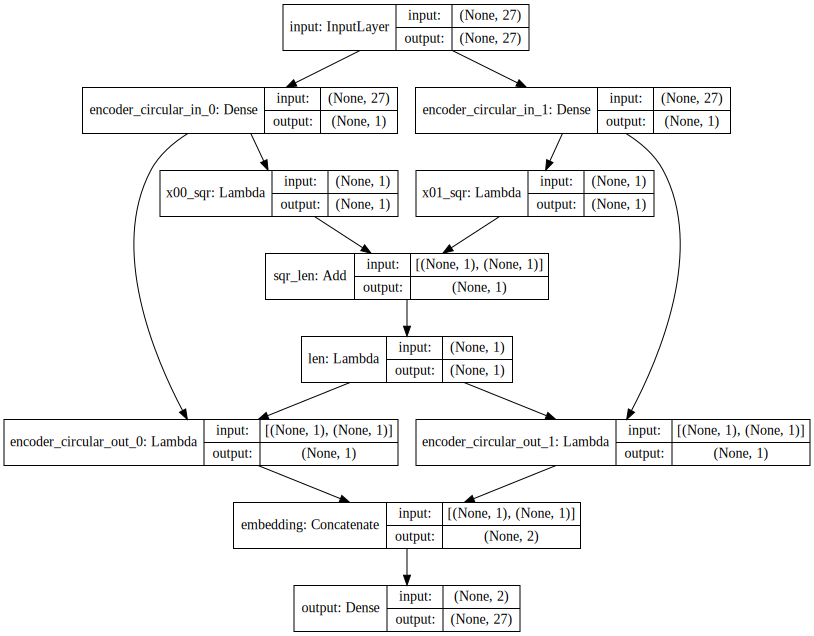

In [9]:
model = cyclops(data.shape[1])
display(model.show_structure())

In [10]:
model.train(data, epochs=1000, verbose=100, rate=2e-4)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch: 100/1000, loss:  0.9655, time elapsed:  5.94s, time left:  53.46s
epoch: 200/1000, loss:  0.9438, time elapsed:  9.56s, time left:  38.25s
epoch: 300/1000, loss:  0.9402, time elapsed:  13.19s, time left:  30.77s
epoch: 400/1000, loss:  0.9393, time elapsed:  17.09s, time left:  25.63s
epoch: 500/1000, loss:  0.9388, time elapsed:  21.01s, time left:  21.01s
epoch: 600/1000, loss:  0.9384, time elapsed:  24.77s, time left:  16.52s
epoch: 700/1000, loss:  0.9380, time elapsed:  28.44s, time left:  12.19s
epoch: 800/1000, loss:  0.9377, time elapsed:  32.14s, time left:  8.04s
epoch: 900/1000, loss:  0.9373, time elapsed:  35.83s, time left:  3.98s
epoch: 1000/1000, loss:  0.9370, time elapsed:  39.56s, time left:  0.00s


In [11]:
pseudotime = model.predict_pseudotime(data)


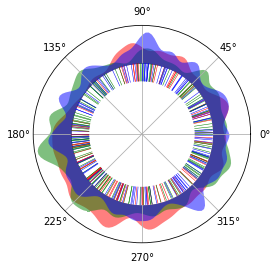

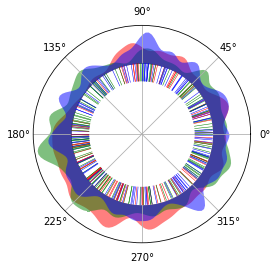

In [12]:
import cyclum.illustration
color_map = {"g0/g1": "red", "s": "green", "g2/m": "blue"}
cyclum.illustration.plot_round_distr_color(pseudotime, cpt.squeeze(), color_map)

(0, 3.141592653589793)

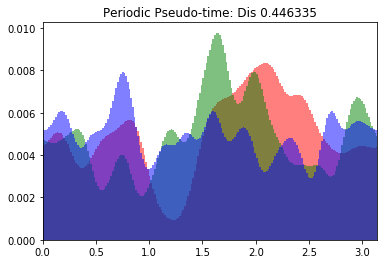

In [13]:
flat_embedding = (pseudotime % (2 * np.pi)) / 2
import cyclum.evaluation

width = 3.14 / 100 / 2;

discrete_time, distr_g0g1 = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g0/g1'])
plt.bar(discrete_time, distr_g0g1, color='red', alpha=0.5, width = width)

discrete_time, distr_s = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='s'])
plt.bar(discrete_time, distr_s, color='green', alpha=0.5, width = width)

discrete_time, distr_g2m = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g2/m'])
plt.bar(discrete_time, distr_g2m, color='blue', alpha=0.5, width = width)

correct_prob = cyclum.evaluation.precision_estimate([distr_g0g1, distr_s, distr_g2m], cpt, ['g0/g1', 's', 'g2/m'])
dis_score = correct_prob
plt.title("Periodic Pseudo-time: Dis %f" % dis_score)
plt.xlim([0, np.pi])

Note that this metric, although similar, is not exactly the same as the one we reported using mclust in R.

We use a non-parametric parzen window method to estimate the distribution here, 
while mclust uses a parametric normal mixture.

In [14]:
from cyclum.hdfrw import mat2hdf

mat2hdf(pseudotime, '/home/shaoheng/Documents/data/McDavid/pc3-cyclops-pseudotime.h5')




